[`yolov7`](https://github.com/WongKinYiu/yolov7/tree/main)

[train_aux.py](https://github.com/WongKinYiu/yolov7/blob/main/train_aux.py#L41) training on large images with more complex models

In [1]:
%matplotlib inline

import os
import re
import sys
import yaml
import random

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

seed=0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed);

## slower, more reproducible
#cudnn.benchmark, cudnn.deterministic = False, True
## faster, less reproducible
#cudnn.benchmark, cudnn.deterministic = True, False

In [2]:

%load_ext autoreload
%autoreload 2

sys.path.append('../../../')
from video_processing.yolov7.parameter_parser import parser
from video_processing.yolov7.models.model import Model
from video_processing.yolov7.models.ema import ModelEMA
from video_processing.yolov7.loss.module import ComputeLoss
from video_processing.yolov7.train.utils import setup_optimizer, labels_to_class_weights, train_an_epoch
from video_processing.yolov7.dataset.penn_fandu_dataset import PennFudanDataset
from video_processing.yolov7.utils.general import one_cycle, check_image_size
from video_processing.yolov7.dataset.anchors import check_anchor_matching
from video_processing.yolov7.test.utils import validate

In [3]:
data_dirpath='D:/data/PennFudanPed'
result_dirpath='D:/results/yolov7'

argument=f"""
--data-dirpath {data_dirpath} --output-dirpath {result_dirpath} 
--worker 1 --device cpu --batch-size 2 --img 1280 1280 --cfg yolov7-w6-pennfandu.yaml
--weights ''  --name yolov7-w6 --hyp hyp.scratch.p6.yaml --correct-exif --print-freq 1
--epochs 5 --dev-mode
"""
# --n-training-data 100 --n-val-data 20 --dev-mode
args=parser.parse_args(argument.split())

device=torch.device('cpu' if not torch.cuda.is_available() or args.device=='cpu' else 'cuda')
print(device, args.batch_size)

if not os.path.isdir(args.output_dirpath):os.makedirs(args.output_dirpath)
args.checkpoint_dirpath=os.path.join(args.output_dirpath, args.checkpoint_dirname)
if not os.path.isdir(args.checkpoint_dirpath): os.makedirs(args.checkpoint_dirpath)

cpu 2


In [4]:
# hyperparameters
with open(args.hyp) as f: hyp=yaml.load(f, Loader=yaml.SafeLoader)
# number of classes
nc=2

In [5]:
# save running
with open(os.path.join(args.output_dirpath, 'hyp.yaml'), 'w') as f: yaml.dump(hyp, f, sort_keys=False)
with open(os.path.join(args.output_dirpath, 'args.yaml'), 'w') as f: yaml.dump(vars(args), f, sort_keys=False)

In [6]:
# train/val data loader
train_dataset=PennFudanDataset(root=args.data_dirpath, image_dirname=args.image_dirname, mask_dirname=args.mask_dirname, hyp=hyp,
                        img_size=args.img_size[0], augment=True,  indices=np.arange(150))
val_dataset=PennFudanDataset(root=args.data_dirpath, image_dirname=args.image_dirname, mask_dirname=args.mask_dirname, hyp=hyp,  
                        img_size=args.img_size[0], augment=False,  indices=np.arange(150,170))

train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=args.batch_size, num_workers=1, pin_memory=True, 
                                        collate_fn=PennFudanDataset.collate_fn)
val_loader=torch.utils.data.DataLoader(dataset=val_dataset, batch_size=args.batch_size, num_workers=1, pin_memory=True, 
                                        collate_fn=PennFudanDataset.collate_fn)

print(f'There are {len(train_dataset)} training images and {len(val_dataset)} validation images ')

There are 150 training images and 20 validation images 


In [7]:
# define model and optimizers
model=Model(args.cfg, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # it is safer to move model to device first and then create optimizer
optimizer=setup_optimizer(model, learning_rate=hyp['lr0'], momentum=hyp['momentum'], weight_decay=hyp['weight_decay'])
scheduler=torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=one_cycle(1., hyp['lrf'], args.epochs))
model_ema=ModelEMA(model)
start_epoch, best_fitness, best_loss=1, -np.inf, np.inf
if args.resume is not None and os.path.isfile(os.path.join(args.checkpoint_dirpath, args.resume)):
    resume_fpath=os.path.join(args.checkpoint_dirpath, args.resume)
    if os.path.isfile(os.path.join(args.checkpoint_dirpath, args.best_checkpoint_fname)):
        resume_fpath=os.path.join(args.checkpoint_dirpath, args.best_checkpoint_fname)
    checkpoint = torch.load(resume_fpath, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    start_epoch = checkpoint['epoch']+1
    if 'best_fitness' in checkpoint: best_fitness=checkpoint['best_fitness'] 
    if 'best_loss' in checkpoint: best_loss=checkpoint['best_loss'] 
    model_ema.ema.load_state_dict(checkpoint['ema'])
    model_ema.updates=checkpoint['updates']

# wrap distributed training

# check that the image size divisible by stride
max_stride=max(int(model.stride.max()), 32)
assert check_image_size(image_size=args.img_size, stride=max_stride), f'{args.img_size} must be divisible by {max_stride}'

In IAxDetect nl: 4 na: 3
In IAxDetect anchors: torch.Size([4, 3, 2]) 4x3x2
In IAxDetect anchor_grid: torch.Size([4, 1, 3, 1, 1, 2]) 4x1x3x1x1x2


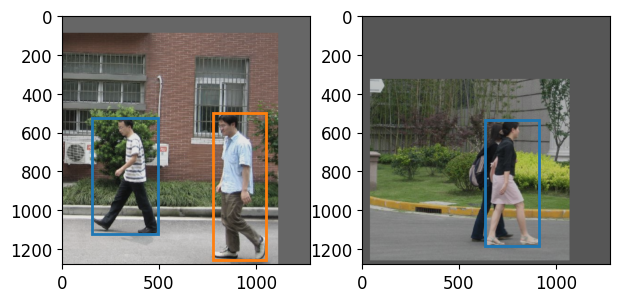

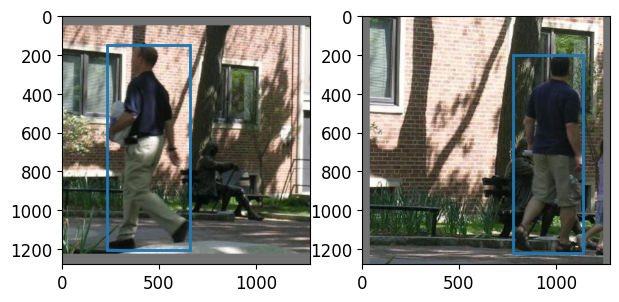

In [8]:
from matplotlib import patches
from video_processing.yolov7.dataset.coords import normalized_xywh2xyxy

cmap = plt.get_cmap('tab10', 10)
plt.rcParams.update({'font.size'   : 12})

imgs, labels, fpath,_=next(iter(train_loader))
_, ax=plt.subplots(1,imgs.shape[0],figsize=(6,3))
for i, img in enumerate(imgs):
    is_box=labels[:,0]==i # box of this image
    boxes=labels[:,2:][is_box]
    boxes=normalized_xywh2xyxy(boxes,w=img.shape[-1], h=img.shape[1])
    ax[i].imshow(img.permute(1,2,0)) # CxHxW to HxWxC
    for j, box in enumerate(boxes):
        # Create a Rectangle patch
        rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
        # Add the patch to the Axes
        ax[i].add_patch(rect)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

imgs, labels, fpath,_=next(iter(val_loader))
_, ax=plt.subplots(1,imgs.shape[0],figsize=(6,3))
for i, img in enumerate(imgs):
    is_box=labels[:,0]==i # box of this image
    boxes=labels[:,2:][is_box]
    boxes=normalized_xywh2xyxy(boxes,w=img.shape[-1], h=img.shape[1])
    ax[i].imshow(img.permute(1,2,0)) # CxHxW to HxWxC
    for j, box in enumerate(boxes):
        # Create a Rectangle patch
        rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
        # Add the patch to the Axes
        ax[i].add_patch(rect)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

In [9]:
# model parameters
nl=model.model[-1].nl
print("hyp['box'] ", hyp['box'],  " hyp['cls'] ", hyp['cls'], " hyp['obj] ", hyp['obj'] )
hyp['box']*=3./nl # box-regression loss weight scaled to layer
hyp['cls']*= nc/80. * 3./nl # classification loss weight scaled to classes and layers
hyp['obj']*=(args.img_size[0]/640)**2 *3./nl # objectness loss weight scaled to image size and layers
hyp['label_smoothing']=args.label_smoothing
model.nc=nc # attach number of classes to model
model.hyp=hyp
# blending factor between fixed objectness of 1 and IoU between prediction and ground truth
# used to set target objectness, i.e., target_objectness = (1-gr)+gr*iou
model.gr=1. 
# model.class_weights=nc*labels_to_class_weights(labels=train_dataset.labels, n_classes=nc).to(device)
# model.names=data_dict['names']
print("hyp['box'] ", hyp['box'],  " hyp['cls'] ", hyp['cls'], " hyp['obj] ", hyp['obj'], ' args.label_smoothing ', args.label_smoothing )
# print('model.class_weights ', model.class_weights)

hyp['box']  0.05  hyp['cls']  0.3  hyp['obj]  0.7
hyp['box']  0.037500000000000006  hyp['cls']  0.005625000000000001  hyp['obj]  2.0999999999999996  args.label_smoothing  0.0


In [10]:
# start training
print('warmup_epochs ', hyp['warmup_epochs'])

scheduler.last_epoch=start_epoch-1 # do not move?
train_loss_module=ComputeLoss(model, cls_pw=hyp['cls_pw'], obj_pw=hyp['obj_pw'], label_smoothing=args.label_smoothing, use_aux=True)
val_loss_module=ComputeLoss(model, cls_pw=hyp['cls_pw'], obj_pw=hyp['obj_pw'], label_smoothing=args.label_smoothing, use_aux=False)

warmup_epochs  3.0


In [11]:
for epoch in range(start_epoch, args.epochs):

    # train a model
    model.train()
    mean_weighted_loss, mean_unweigthed_loss=train_an_epoch(args, model, model_ema, optimizer, train_loss_module, train_loader, epoch=epoch)

    # scheduler
    scheduler.step()

    # mAP validation model
    model_ema.update_attr(model, include=['yaml', 'nc', 'hyp', 'gr', 'names', 'stride']) #, 'class_weights'])

    # validation
    mean_val_weighted_loss,mean_val_unweighted_loss=validate(model=model_ema.ema, dataloader=val_loader, val_loss_module=val_loss_module, hyp=hyp, 
                                        n_its=1 if args.dev_mode else None)
    

    lr_txt=', '.join([f"{params['lr']:.3f}"  for params in optimizer.param_groups])
    val_txt=', '.join(f'{n}:{v.item():.3f}' for n, v in zip('bb,obj,cls'.split(','),mean_val_unweighted_loss))
    print(f'Epoch {epoch}: train-loss={mean_weighted_loss[0].item():.3f}, val-loss={mean_val_weighted_loss[0].item():.3f}, {val_txt} lr=({lr_txt})', flush=True)

    # save parameters
    training_state_dict={'epoch': epoch, 'model': model.state_dict(), 'ema':model_ema.ema.state_dict(),  'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(), 'updates':model_ema.updates, 'best_loss': best_loss}
    torch.save(training_state_dict, os.path.join(args.checkpoint_dirpath, args.resume))
    if mean_val_weighted_loss[0].item() < best_loss:
        best_loss=mean_val_weighted_loss[0].item()
        training_state_dict['best_loss']=best_loss
        torch.save(training_state_dict, os.path.join(args.checkpoint_dirpath, args.best_checkpoint_fname))
    break

In train.utils n_warmup 1000
1 [1.33%]: loss:0.783,  w-bb:0.016, w-obj:0.765, w-cls:0.002 | bb:0.432, obj:0.364, cls:0.414 | acc 3.0
Epoch 2: train-loss=0.783, val-loss=1.393, bb:0.710, obj:0.649, cls:0.724 lr=(0.001, 0.001, 0.001)


In [13]:
mean_weighted_loss, mean_val_weighted_loss

(tensor([0.7835, 0.0162, 0.7650, 0.0023]),
 tensor([1.3932, 0.0266, 1.3625, 0.0041]))

In [17]:
log=', '.join(f'{x.item()}' for x in mean_weighted_loss) + \
', '.join(f'{x.item()}' for x in mean_unweigthed_loss) + \
', '.join(f'{x.item()}' for x in mean_val_weighted_loss) + \
', '.join(f'{x.item()}' for x in mean_val_unweighted_loss) 
log

'0.7834972143173218, 0.01619059033691883, 0.7649803757667542, 0.00232625473290681840.4317490756511688, 0.36427637934684753, 0.413556367158889771.393216848373413, 0.02661963738501072, 1.3625247478485107, 0.0040724282152950760.7098569869995117, 0.6488213539123535, 0.7239872217178345'

In [ ]:
't-w-loss, t-w-bb, t-w-obj, t-w-cls, t-bb, t-obj, t-cls, v-w-loss, v-w-bb, v-w-obj, v-w-cls, v-bb, v-obj, v-cls'

In [21]:
mean_unweigthed_loss, mean_val_unweighted_loss

(tensor([0.4317, 0.3643, 0.4136]), tensor([0.7099, 0.6488, 0.7240]))

In [20]:
train_log = open(args.train_log, 'a')
train_log.write('t-w-loss, t-w-bb, t-w-obj, t-w-cls, t-bb, t-obj, t-cls, v-w-loss, v-w-bb, v-w-obj, v-w-cls, v-bb, v-obj, v-cls\n')
train_log.close()

train_log = open(args.train_log, 'a')
train_log.write(log+'\n')
train_log.close()

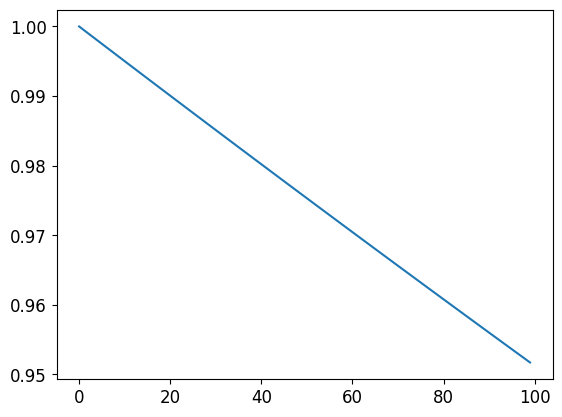

In [19]:
import math 

updates=np.arange(100)
w=0.9999
decay=lambda x: w*(1.-math.exp(-x/2000.))
y=[1.-decay(u) for u in updates]
plt.plot(updates, y)